In [ ]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import time
import torchvision.models as models
from matplotlib import pyplot as plt

In [ ]:
device = torch.device("mps" if torch.mps.is_available() else "cpu")
device

device(type='mps')

## Load Data and Transform


In [ ]:
image_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
dataset_path = "./dataset"

dataset = datasets.ImageFolder(root=dataset_path, transform=image_transforms)
len(dataset)

2300

In [21]:
dataset.classes

['F_Breakage', 'F_Crushed', 'F_Normal', 'R_Breakage', 'R_Crushed', 'R_Normal']

In [ ]:
num_classes = len(dataset.classes)
num_classes

6

In [ ]:
train_size = int(0.75 * len(dataset))
test_size = len(dataset) - train_size

In [24]:
from torch.utils.data import random_split

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
len(train_dataset), len(test_dataset)

(1725, 575)

In [25]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [26]:
for images, labels in train_loader:
    print(images.shape)
    print(labels.shape)
    break

torch.Size([32, 3, 224, 224])
torch.Size([32])


In [ ]:
images[1].permute(1, 2, 0).shape

torch.Size([224, 224, 3])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


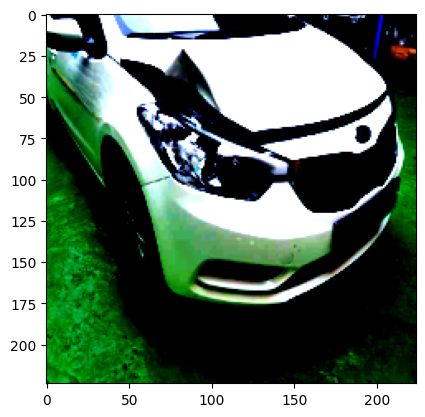

In [ ]:
plt.imshow(images[1].permute(1, 2, 0))
plt.show()

## Model : CNN


In [ ]:
class CarClassifierCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3,
                      stride=1, padding=1),  # (16, 224, 224)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2,
                         padding=0),  # (16, 112, 112),
            nn.Conv2d(in_channels=16, out_channels=32,
                      kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),  # (32, 56, 56)
            nn.Conv2d(in_channels=32, out_channels=64,
                      kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),  # (64, 28, 28),
            nn.Flatten(),
            nn.Linear(64*28*28, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.network(x)
        return x

In [34]:
images.size(0)

32

In [35]:
len(train_loader.dataset)

1725

In [ ]:
def train_model(model, criterion, optimizer, epochs=5):
    start = time.time()

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for batch_num, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            if (batch_num+1) % 10 == 0:
                print(
                    f"Batch: {batch_num+1}, Epoch: {epoch+1}, Loss: {loss.item():0.2f}")

            running_loss += loss.item() * images.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        print(f"Epoch [{epoch+1}/{epochs}], Avg Loss: {epoch_loss:.4f}")

        # Validation
        model.eval()
        correct = 0
        total = 0
        all_labels = []
        all_predictions = []

        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                all_labels.extend(labels.cpu().numpy())
                all_predictions.extend(predicted.cpu().numpy())

            print(f"*** Validation Accuracy: {100 * correct / total:.2f}% ***")

    end = time.time()
    print(f"Execution time: {end - start} seconds")

    return all_labels, all_predictions

In [ ]:
model = CarClassifierCNN(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

all_labels, all_predictions = train_model(
    model, criterion, optimizer, epochs=10)

Batch: 10, Epoch: 1, Loss: 1.79
Batch: 20, Epoch: 1, Loss: 1.79
Batch: 30, Epoch: 1, Loss: 1.77
Batch: 40, Epoch: 1, Loss: 1.72
Batch: 50, Epoch: 1, Loss: 1.50
Epoch [1/10], Avg Loss: 1.8791
*** Validation Accuracy: 40.70% ***
Batch: 10, Epoch: 2, Loss: 1.56
Batch: 20, Epoch: 2, Loss: 1.35
Batch: 30, Epoch: 2, Loss: 1.28
Batch: 40, Epoch: 2, Loss: 1.24
Batch: 50, Epoch: 2, Loss: 1.25
Epoch [2/10], Avg Loss: 1.3261
*** Validation Accuracy: 46.26% ***
Batch: 10, Epoch: 3, Loss: 1.28
Batch: 20, Epoch: 3, Loss: 0.97
Batch: 30, Epoch: 3, Loss: 1.17
Batch: 40, Epoch: 3, Loss: 1.21
Batch: 50, Epoch: 3, Loss: 1.37
Epoch [3/10], Avg Loss: 1.1820
*** Validation Accuracy: 51.30% ***
Batch: 10, Epoch: 4, Loss: 0.96
Batch: 20, Epoch: 4, Loss: 1.07
Batch: 30, Epoch: 4, Loss: 1.06
Batch: 40, Epoch: 4, Loss: 1.20
Batch: 50, Epoch: 4, Loss: 0.86
Epoch [4/10], Avg Loss: 1.0389
*** Validation Accuracy: 51.83% ***
Batch: 10, Epoch: 5, Loss: 0.82
Batch: 20, Epoch: 5, Loss: 0.90
Batch: 30, Epoch: 5, Loss: 1